In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packag

In [5]:
# !pip install vector-quantize-pytorch

In [6]:
import mushroom.utils as utils

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [8]:
mushroom_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': .001,
        'recon_scaler': 1.,
        'encoder_dim': 128,
        'decoder_dim': 128
    },
    'learner_kwargs': {
        'scale': .1,
        'pct_expression': .02,
        'batch_size': 32,
        'num_workers': 1,
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 1000,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [9]:
# for config_fp in config_fps:
#     config = yaml.safe_load(open(config_fp))
#     case = config_fp.split('/')[-2]
#     print(case)
    
#     out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}/outputs')
#     chkpt_dir = os.path.join(out_dir, 'chkpts')
#     Path(chkpt_dir).mkdir(parents=True, exist_ok=True)
    
#     mushroom_config['sections'] = config
#     mushroom_config['train_kwargs']['save_dir'] = chkpt_dir
    
#     mushroom = Mushroom.from_config(mushroom_config)
    
#     mushroom.train()
#     mushroom.chkpt_filepath = ''
#     mushroom.embed_sections()
#     mushroom.cluster_sections(margin=.05)

#     mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))
#     mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))
    
# #     break
    
    

In [10]:
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'
config = yaml.safe_load(open(config_fp))
case = config_fp.split('/')[-2]

out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_vae/outputs')
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [11]:
mushroom_config['sections'] = config
mushroom_config['train_kwargs']['save_dir'] = chkpt_dir

In [12]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda
INFO:root:generating inputs for visium tissue sections
INFO:root:using 11622 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [13]:
b = next(iter(mushroom.learner.train_dl))

In [14]:
with torch.no_grad():
    
    device = mushroom.learner.device
    img_x = torch.stack((b['anchor_img'], b['pos_img'], b['neg_img']))
    section_x = torch.stack((b['anchor_idx'], b['pos_idx'], b['neg_idx']))
    img_x, section_x = img_x.to(device), section_x.to(device)

    losses, outputs = mushroom.learner.sae(img_x, section_x)

In [15]:
losses

{'overall_loss': tensor(0.9093, device='cuda:0'),
 'recon_loss': tensor(0.8738, device='cuda:0'),
 'triplet_loss': tensor(35.5427, device='cuda:0')}

In [16]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(0.9495, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9141, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(35.3593, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1_vae/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(0.7541, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7354, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(18.6595, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 20: {'overall_loss': tensor(0.7204, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7089, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.5180, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 30: {'overall_loss': tensor(0.5798, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5710, device='cuda:0', grad_f

INFO:root:iteration 340: {'overall_loss': tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3725, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(2.9706, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 350: {'overall_loss': tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3952, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(11.2907, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 360: {'overall_loss': tensor(0.3995, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3779, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(21.6021, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 370: {'overall_loss': tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3734, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(23.5139, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 380: 

INFO:root:iteration 680: {'overall_loss': tensor(0.3257, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3221, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.5904, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 690: {'overall_loss': tensor(0.3011, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2975, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.5851, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 700: {'overall_loss': tensor(0.3165, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3129, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.5883, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 710: {'overall_loss': tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2876, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.2757, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 720: {'o

INFO:root:iteration 1020: {'overall_loss': tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4698, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(2.4781, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1030: {'overall_loss': tensor(0.4320, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4297, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(2.2625, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1040: {'overall_loss': tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4720, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(2.2261, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1050: {'overall_loss': tensor(0.3626, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3605, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(2.1185, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1060

INFO:root:iteration 1360: {'overall_loss': tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4251, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(1.0830, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1370: {'overall_loss': tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5713, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(1.1562, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1380: {'overall_loss': tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5286, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(1.0761, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1390: {'overall_loss': tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4731, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(1.0271, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1400

INFO:root:iteration 1700: {'overall_loss': tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3283, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(7.9293, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1710: {'overall_loss': tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4117, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.3810, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1720: {'overall_loss': tensor(0.3933, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3831, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(10.2535, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 1730: {'overall_loss': tensor(0.3497, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3416, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(8.1551, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 17

INFO:root:iteration 2040: {'overall_loss': tensor(0.3933, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3833, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(9.9450, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2050: {'overall_loss': tensor(0.3422, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3293, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(12.9469, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2060: {'overall_loss': tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3202, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(16.5358, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2070: {'overall_loss': tensor(0.3508, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3332, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(17.6382, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2

INFO:root:iteration 2380: {'overall_loss': tensor(0.3341, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3255, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(8.5742, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2390: {'overall_loss': tensor(0.3161, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3076, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(8.4344, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2400: {'overall_loss': tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3087, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(8.1938, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2410: {'overall_loss': tensor(0.2692, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2611, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(8.0715, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2420

INFO:root:iteration 2720: {'overall_loss': tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3281, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.1644, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2730: {'overall_loss': tensor(0.3279, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3229, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.0087, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2740: {'overall_loss': tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3552, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.1470, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2750: {'overall_loss': tensor(0.3359, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3307, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.1365, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 2760

INFO:root:iteration 3060: {'overall_loss': tensor(0.4032, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3985, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.6093, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3070: {'overall_loss': tensor(0.3231, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3187, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.4608, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3080: {'overall_loss': tensor(0.2787, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2744, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.3333, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3090: {'overall_loss': tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3450, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.3094, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3100

INFO:root:iteration 3400: {'overall_loss': tensor(0.3293, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3239, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.3133, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3410: {'overall_loss': tensor(0.2902, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2848, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.3875, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3420: {'overall_loss': tensor(0.3243, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3191, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.2438, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3430: {'overall_loss': tensor(0.2658, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2606, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.1778, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3440

INFO:root:iteration 3740: {'overall_loss': tensor(0.2597, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2535, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(6.2443, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3750: {'overall_loss': tensor(0.2842, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2784, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.7911, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3760: {'overall_loss': tensor(0.2690, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2631, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.8890, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3770: {'overall_loss': tensor(0.2599, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2543, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.6022, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 3780

INFO:root:iteration 4080: {'overall_loss': tensor(0.3129, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3071, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.7903, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4090: {'overall_loss': tensor(0.2955, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2898, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.7529, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4100: {'overall_loss': tensor(0.3125, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3068, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.6735, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4110: {'overall_loss': tensor(0.3150, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3092, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.7970, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4120

INFO:root:iteration 4430: {'overall_loss': tensor(0.3065, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3007, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.7790, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4440: {'overall_loss': tensor(0.3269, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3211, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.7739, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4450: {'overall_loss': tensor(0.2774, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2723, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.1261, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4460: {'overall_loss': tensor(0.3319, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3265, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.4600, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4470

INFO:root:iteration 4770: {'overall_loss': tensor(0.2223, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2179, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.3965, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4780: {'overall_loss': tensor(0.2364, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2318, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.6452, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4790: {'overall_loss': tensor(0.2569, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2524, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.4987, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4800: {'overall_loss': tensor(0.2502, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2454, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.7893, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 4810

INFO:root:iteration 5110: {'overall_loss': tensor(0.3106, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3053, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.3784, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5120: {'overall_loss': tensor(0.2946, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2893, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.2960, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5130: {'overall_loss': tensor(0.2938, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2883, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.5668, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5140: {'overall_loss': tensor(0.2860, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2808, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.1717, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5150

INFO:root:iteration 5450: {'overall_loss': tensor(0.2511, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2464, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.6663, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5460: {'overall_loss': tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2570, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.9646, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5470: {'overall_loss': tensor(0.2979, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2926, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.2328, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5480: {'overall_loss': tensor(0.2840, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2787, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.2902, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5490

INFO:root:iteration 5790: {'overall_loss': tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2509, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.7499, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5800: {'overall_loss': tensor(0.3013, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2960, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.2922, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5810: {'overall_loss': tensor(0.2794, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2745, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.9129, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5820: {'overall_loss': tensor(0.3099, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3042, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.6669, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 5830

INFO:root:iteration 6130: {'overall_loss': tensor(0.2789, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2741, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.7816, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6140: {'overall_loss': tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2190, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.0410, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6150: {'overall_loss': tensor(0.2642, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2598, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.4270, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6160: {'overall_loss': tensor(0.2374, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2331, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.2990, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6170

INFO:root:iteration 6470: {'overall_loss': tensor(0.2612, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2567, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.5082, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6480: {'overall_loss': tensor(0.2996, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2947, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.8776, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6490: {'overall_loss': tensor(0.2595, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2549, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.6194, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6500: {'overall_loss': tensor(0.3331, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3273, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.7139, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6510

INFO:root:iteration 6810: {'overall_loss': tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2001, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.8505, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6820: {'overall_loss': tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2198, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.0869, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6830: {'overall_loss': tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3055, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.2750, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6840: {'overall_loss': tensor(0.2455, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2408, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.6137, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 6850

INFO:root:iteration 7150: {'overall_loss': tensor(0.2857, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2808, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.8734, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7160: {'overall_loss': tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2398, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.4534, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7170: {'overall_loss': tensor(0.2260, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2219, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.0678, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7180: {'overall_loss': tensor(0.2457, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2412, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.4466, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7190

INFO:root:iteration 7490: {'overall_loss': tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1998, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.7979, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7500: {'overall_loss': tensor(0.3016, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2968, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.8141, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7510: {'overall_loss': tensor(0.2105, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2066, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.8257, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7520: {'overall_loss': tensor(0.3032, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2979, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.3677, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7530

INFO:root:iteration 7830: {'overall_loss': tensor(0.3160, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(5.2718, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7840: {'overall_loss': tensor(0.2956, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2908, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.8741, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7850: {'overall_loss': tensor(0.2476, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2432, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.4133, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7860: {'overall_loss': tensor(0.2353, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2311, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.1263, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 7870

INFO:root:iteration 8170: {'overall_loss': tensor(0.2804, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2760, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.3689, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8180: {'overall_loss': tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2307, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.9073, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8190: {'overall_loss': tensor(0.2857, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2812, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.5438, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8200: {'overall_loss': tensor(0.2611, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2569, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.2520, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8210

INFO:root:iteration 8510: {'overall_loss': tensor(0.2671, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2631, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.9774, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8520: {'overall_loss': tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2026, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.3112, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8530: {'overall_loss': tensor(0.2676, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2635, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.0739, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8540: {'overall_loss': tensor(0.2200, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2165, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.4712, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8550

INFO:root:iteration 8850: {'overall_loss': tensor(0.2958, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2916, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(4.1149, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8860: {'overall_loss': tensor(0.2296, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2262, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.3844, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8870: {'overall_loss': tensor(0.2687, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2649, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.8706, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8880: {'overall_loss': tensor(0.2712, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2674, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.8820, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 8890

INFO:root:iteration 9190: {'overall_loss': tensor(0.2898, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2859, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.8375, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9200: {'overall_loss': tensor(0.2901, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2862, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.8778, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9210: {'overall_loss': tensor(0.2606, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2571, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.4832, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9220: {'overall_loss': tensor(0.2187, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2158, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(2.9935, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9230

INFO:root:iteration 9530: {'overall_loss': tensor(0.2597, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2563, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.3865, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9540: {'overall_loss': tensor(0.2279, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2248, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.0542, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9550: {'overall_loss': tensor(0.3180, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3142, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.8376, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9560: {'overall_loss': tensor(0.2763, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2728, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.4750, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9570

INFO:root:iteration 9870: {'overall_loss': tensor(0.2347, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2316, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.0301, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9880: {'overall_loss': tensor(0.2366, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2337, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(2.8927, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9890: {'overall_loss': tensor(0.2894, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2860, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(3.3417, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9900: {'overall_loss': tensor(0.2373, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2345, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(2.7908, device='cuda:0', grad_fn=<DivBackward0>)}
INFO:root:iteration 9910

In [15]:
# mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))

In [21]:
# mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))

In [25]:
os.path.join(out_dir, 'outputs.pt')

'/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt'

In [27]:
d = torch.load('/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt')
d.keys()

dict_keys(['recon_embs', 'recon_imgs', 'true_imgs', 'cluster_distances', 'cluster_distance_volume', 'cluster_centroids', 'cluster_ids'])

In [28]:
d['recon_embs']

tensor([[[[ 2.3089e-01,  2.5042e-01,  4.0160e-02,  ...,  2.5042e-01,
            4.0160e-02,  3.1269e-01],
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          ...,
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          [ 1.6370e-01, -1.5678e-02,  2.3870e-01,  ..., -1.5678e-02,
            2.3870e-01,  2.3675e-01]],

         [[-1.2238e-03,  2.2336e-02,  1.0044e-02,  ...,  2.2336e-02,
            1.0044e-02, -1.7283e-02],
          [ 4.2599e-02,  2.7280e-02,  9.8601e-02,  ...,  2.7280e-02,
            9.8601e-02,  1.3791e-02],
          [-3.0337e-02,  1.7819e-02,  7.7605e-02,  ...,  1.7819e-02,
            7.7605e-02,  9.4206e-02],
          ...,
     

In [14]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/chkpts/500iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [22]:
mushroom.chkpt_filepath = ''
mushroom.cluster_kwargs['centroids'] = None

In [17]:
mushroom.embed_sections()

In [18]:
# mushroom.recon_embs_prequant.shape

In [19]:
from einops import rearrange
dists = torch.cdist(rearrange(mushroom.recon_embs_prequant, 'n d h w -> n h w d'),
                    mushroom.learner.sae.vq.codebook.clone().cpu()).detach().cpu()
dists.shape

RuntimeError: Tensor type unknown to einops <class 'NoneType'>

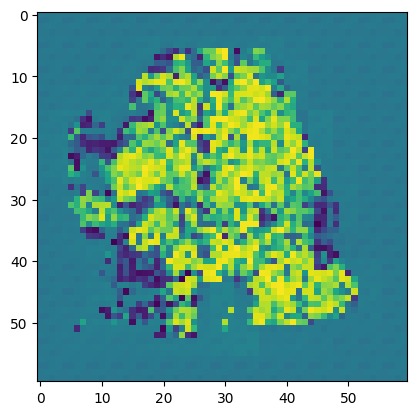

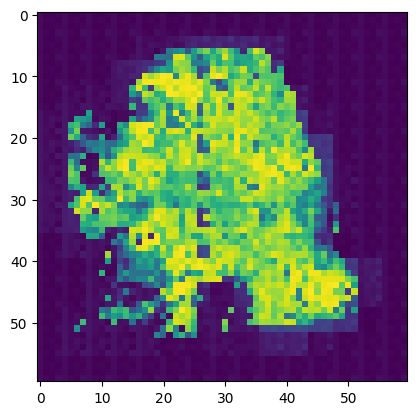

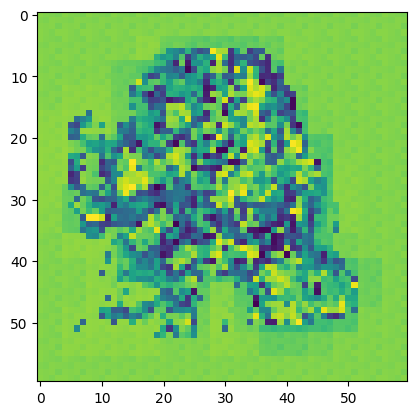

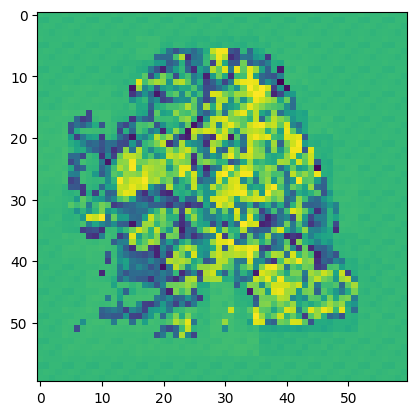

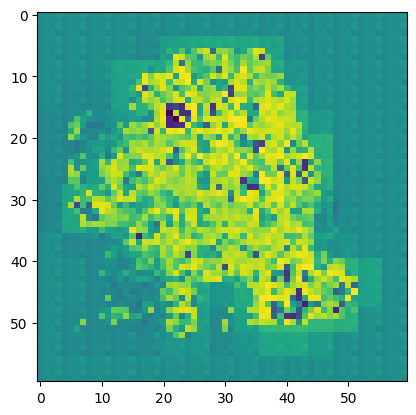

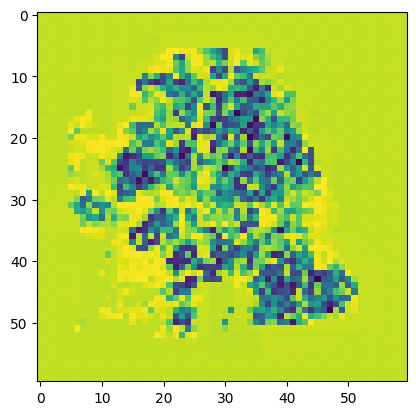

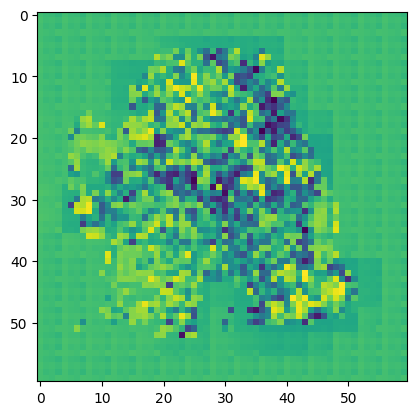

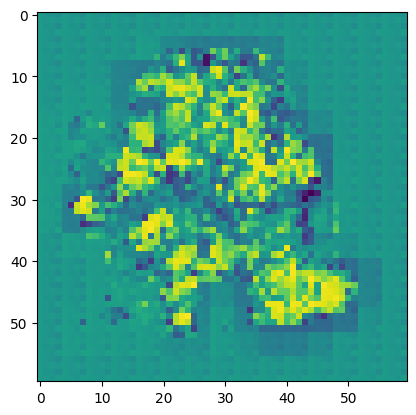

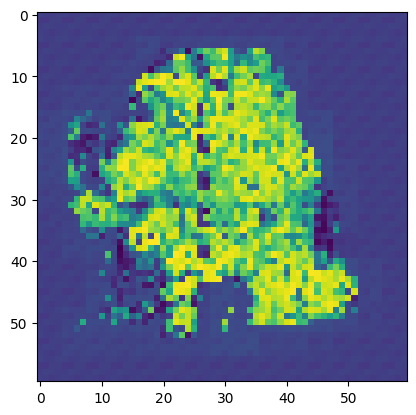

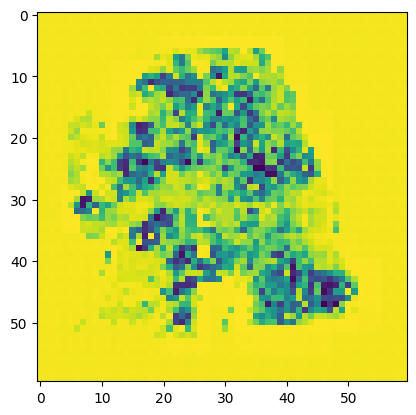

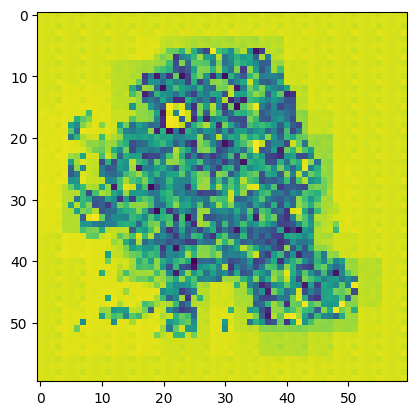

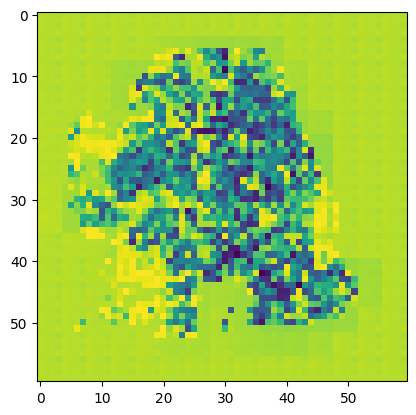

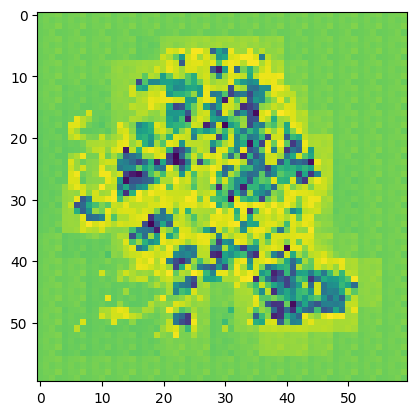

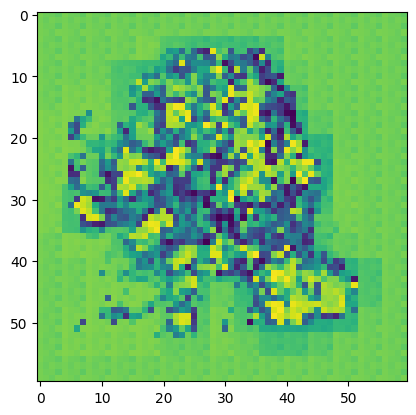

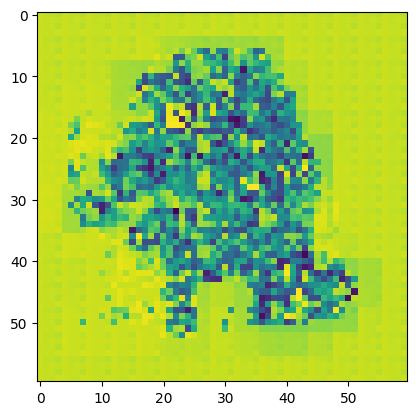

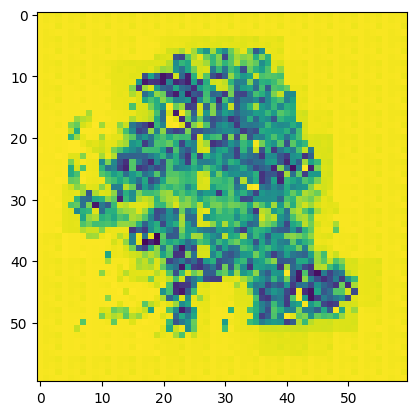

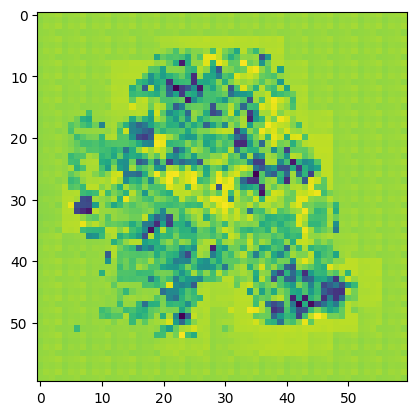

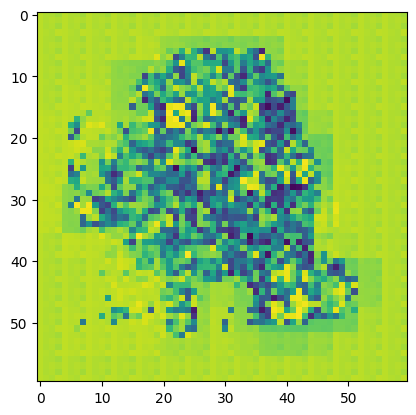

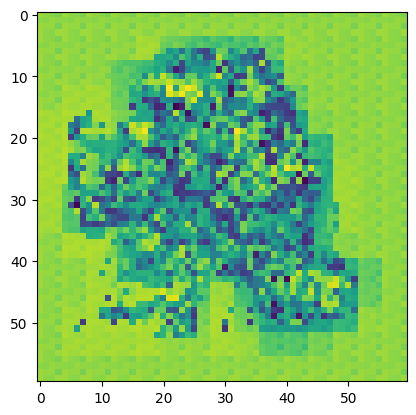

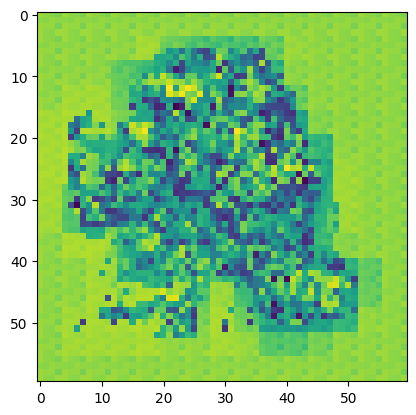

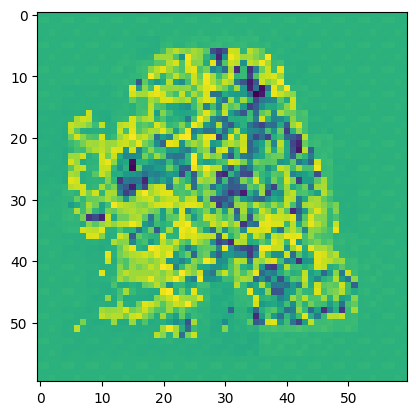

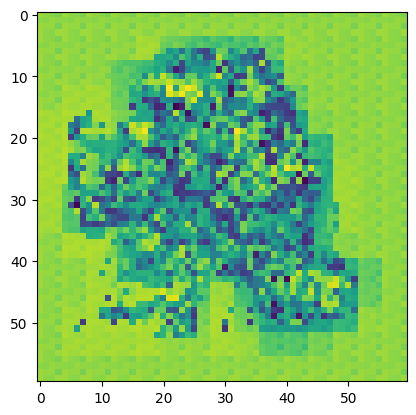

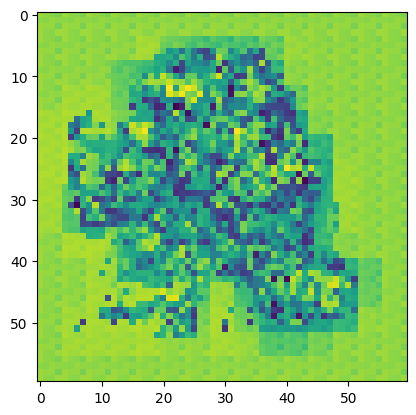

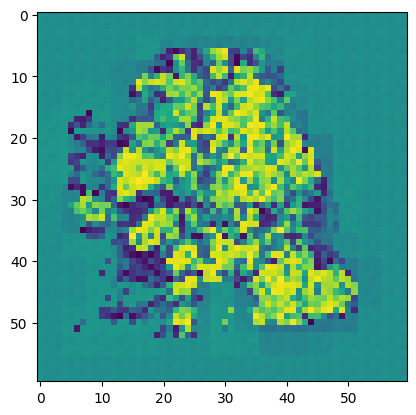

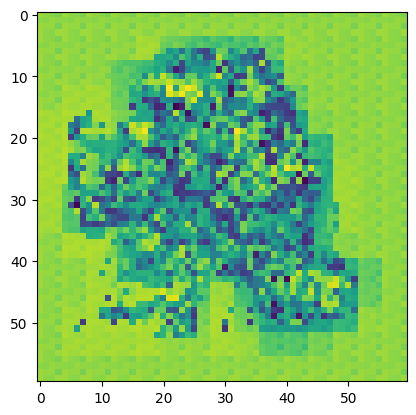

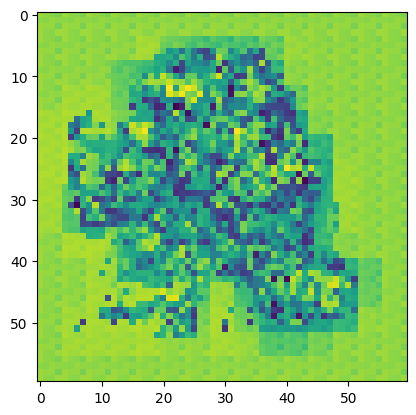

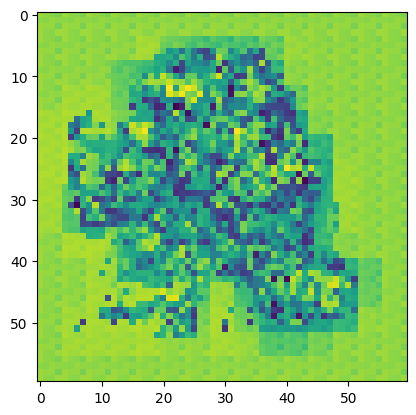

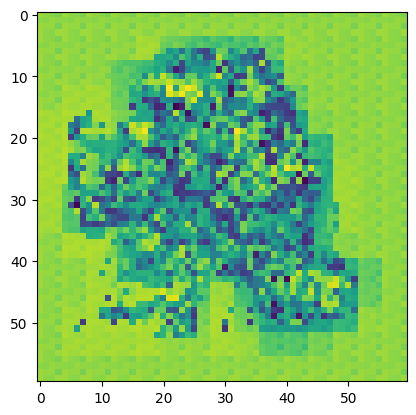

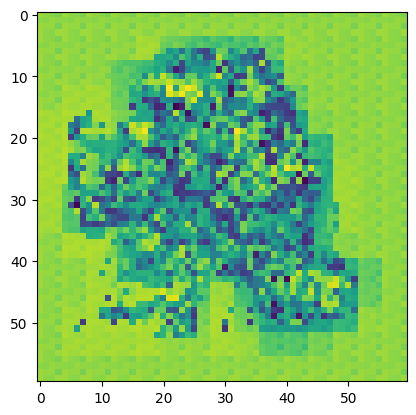

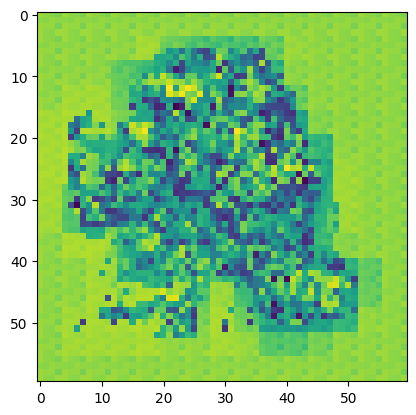

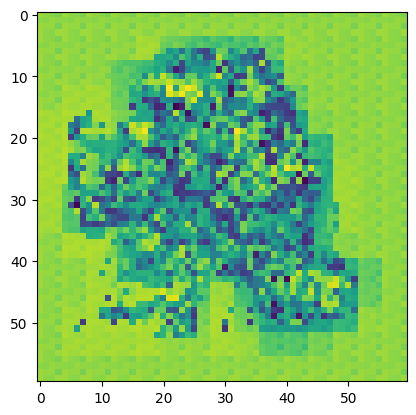

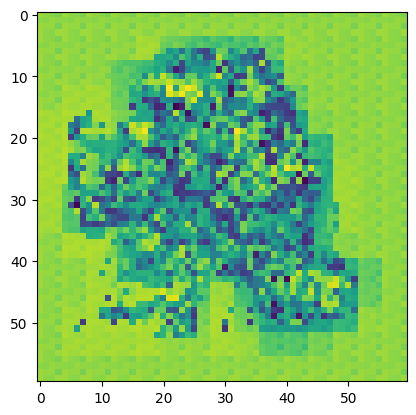

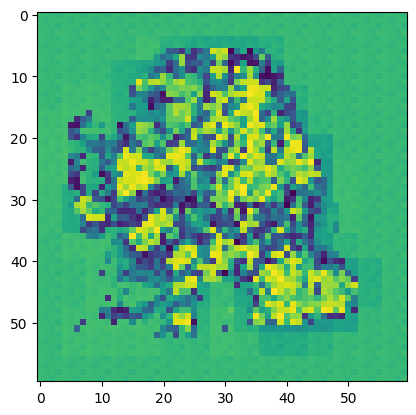

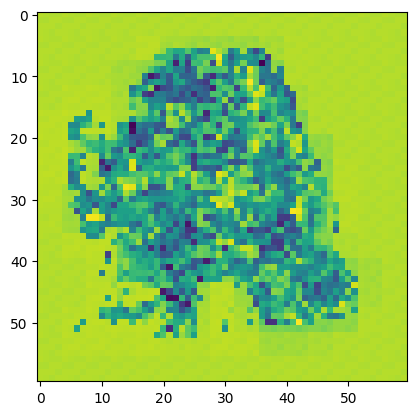

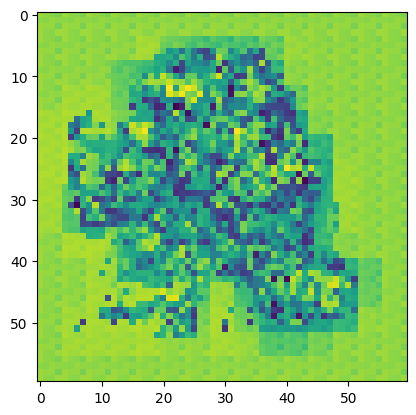

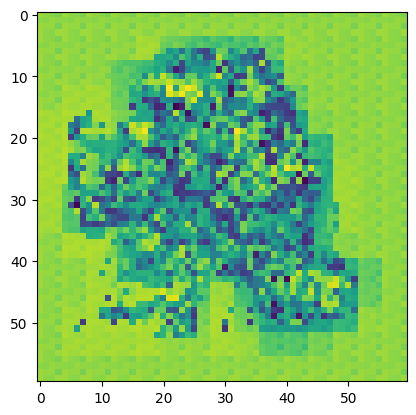

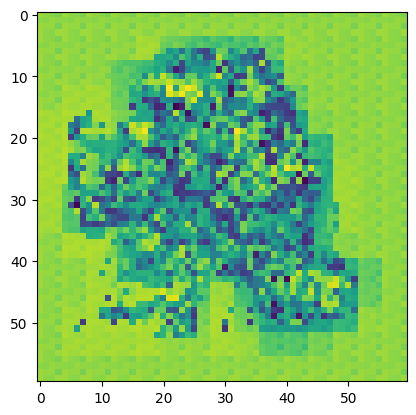

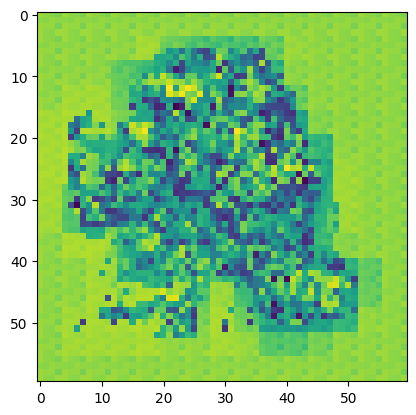

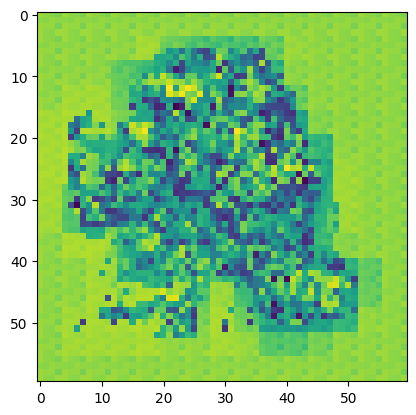

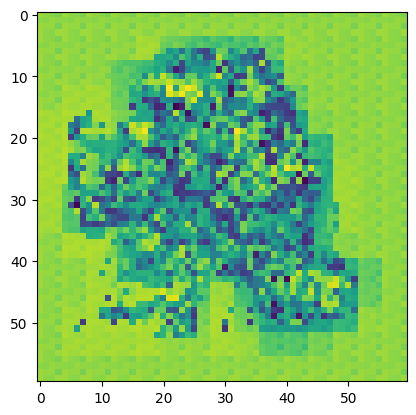

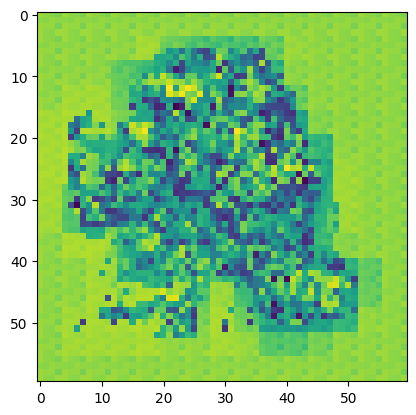

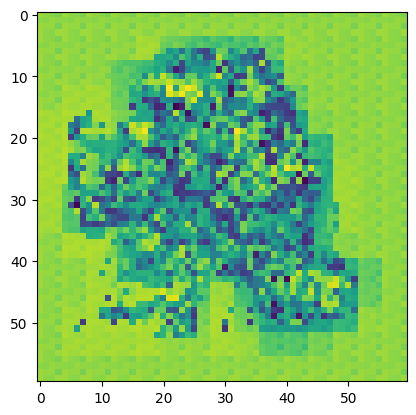

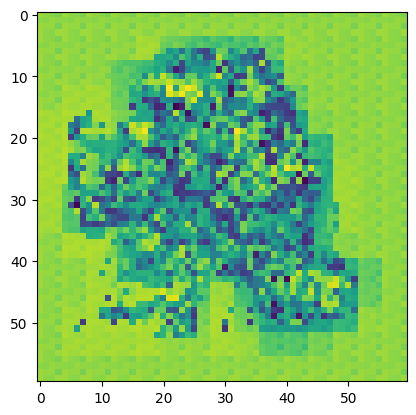

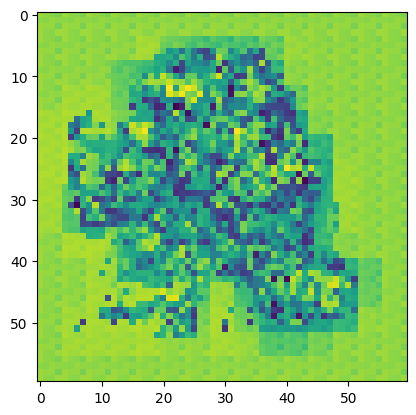

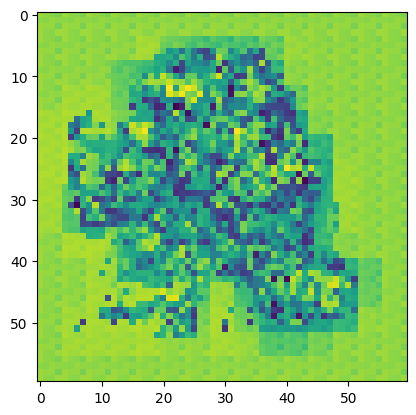

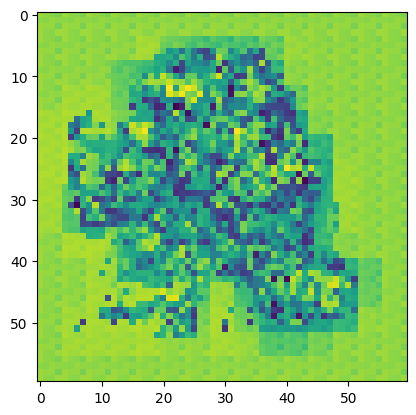

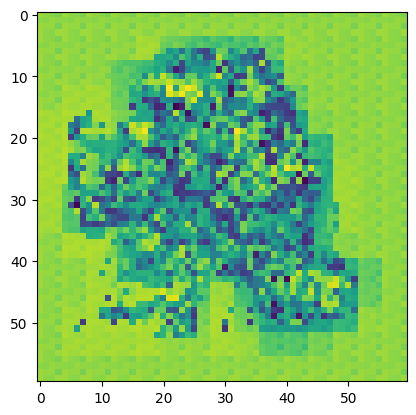

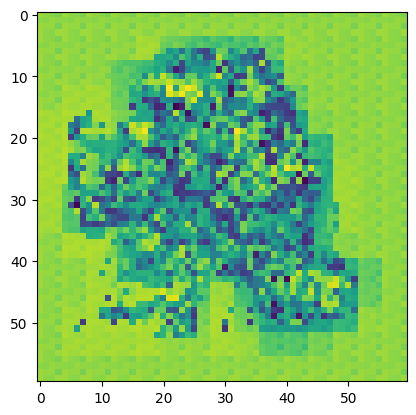

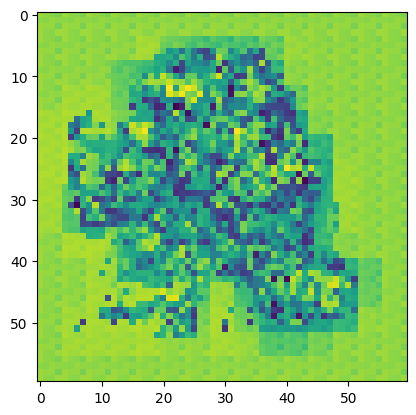

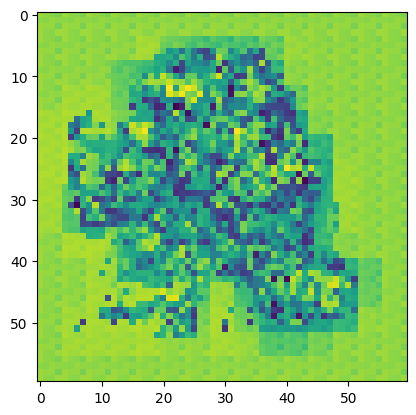

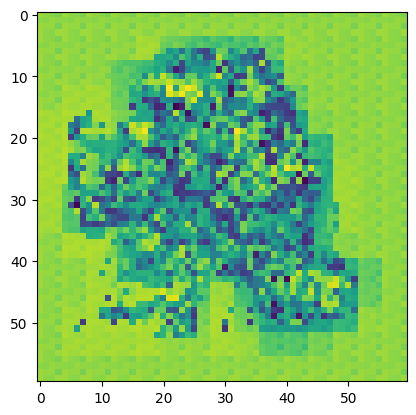

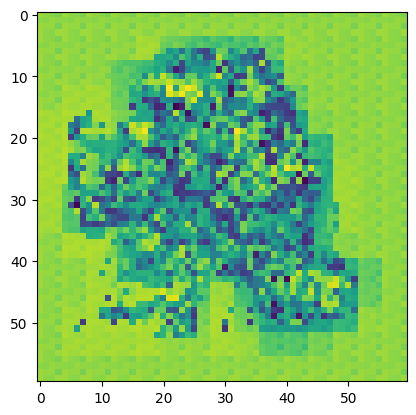

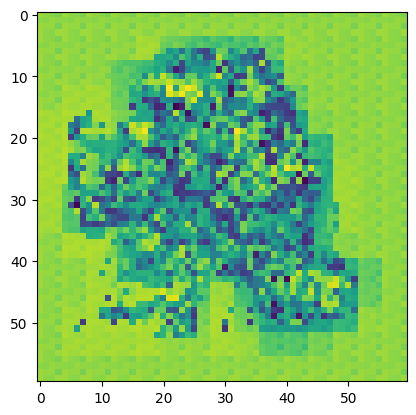

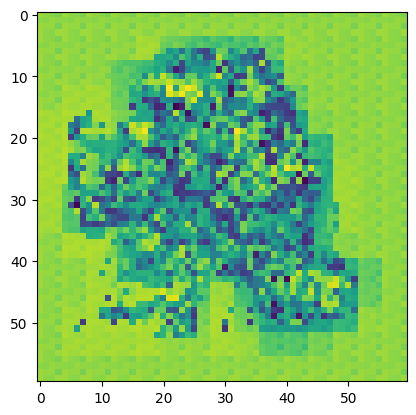

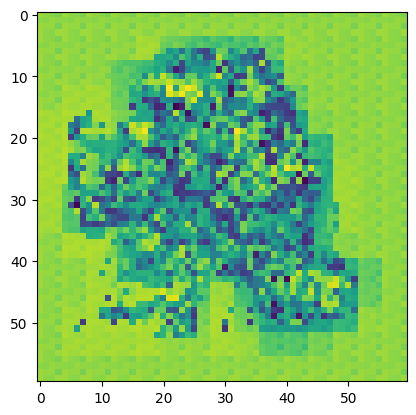

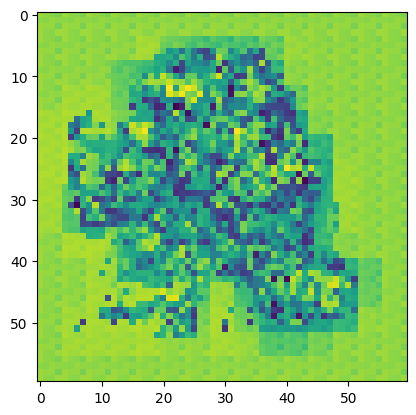

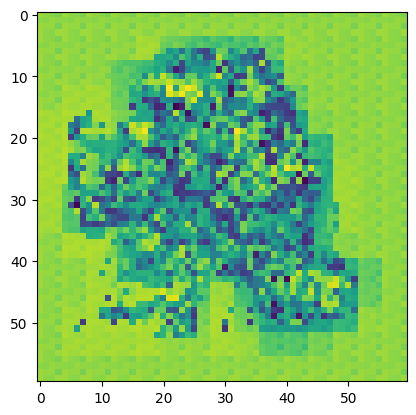

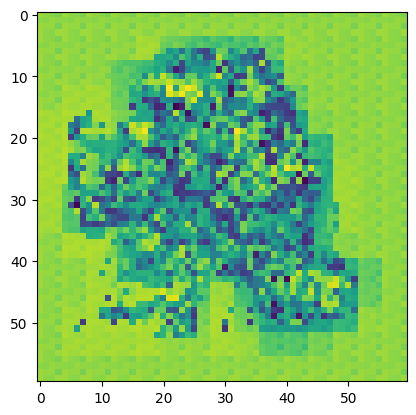

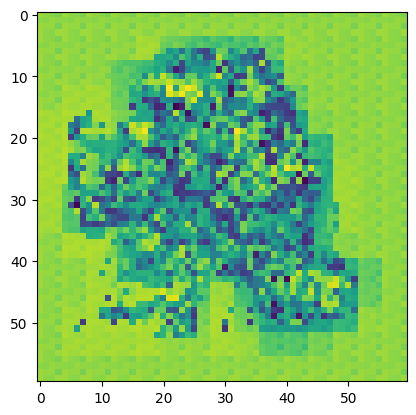

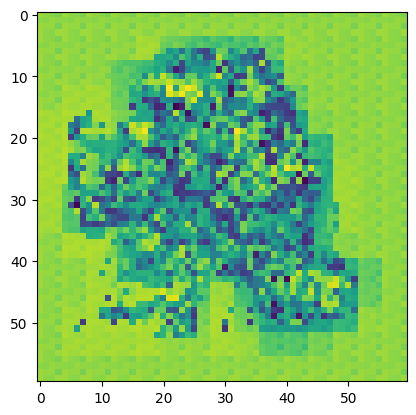

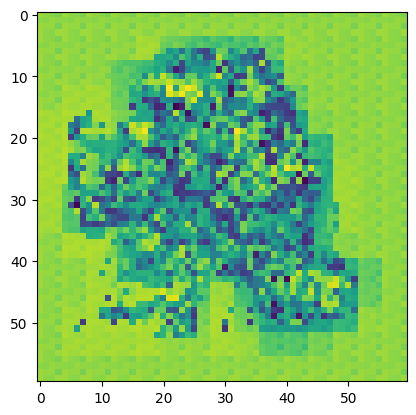

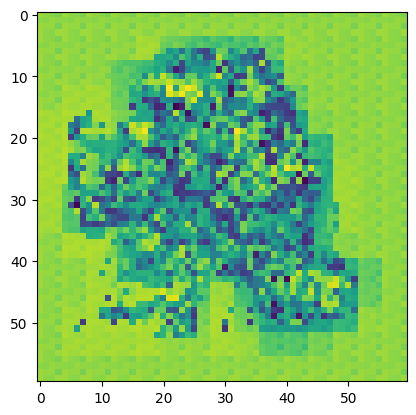

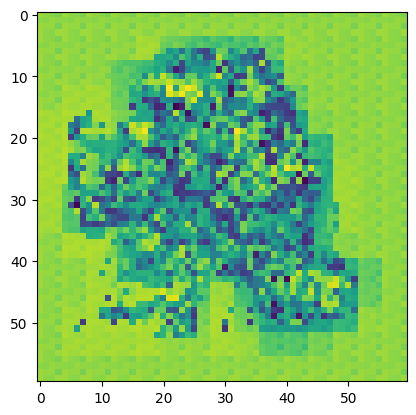

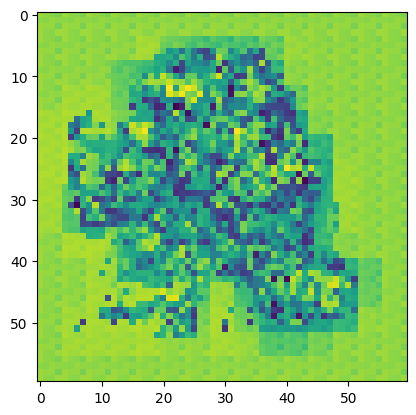

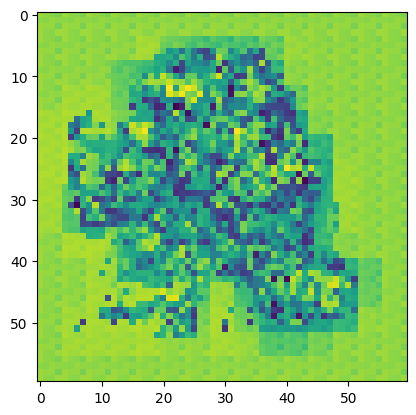

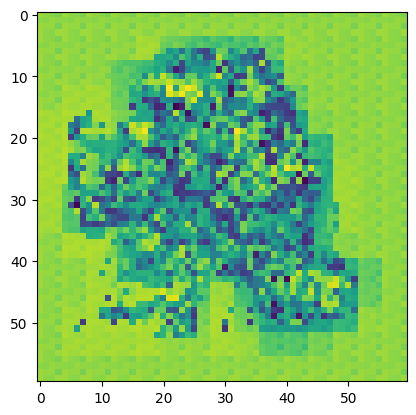

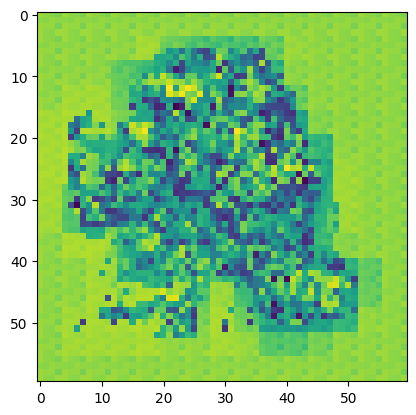

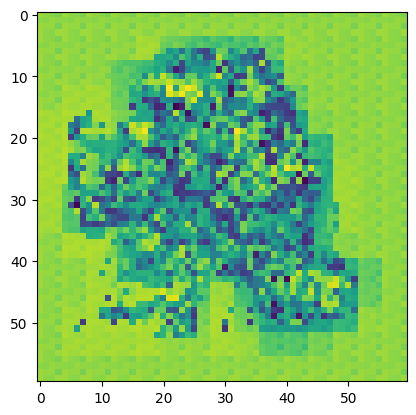

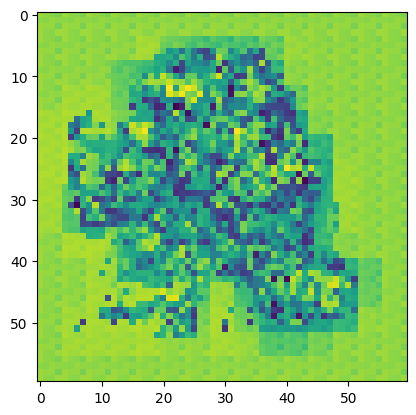

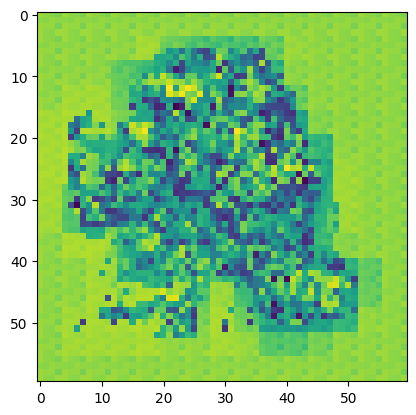

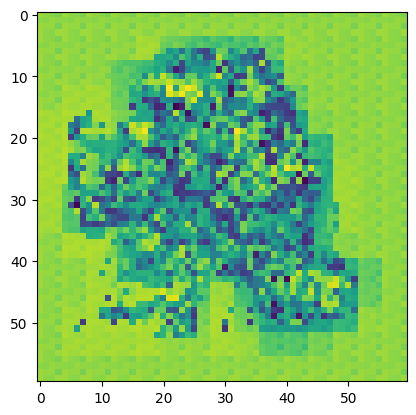

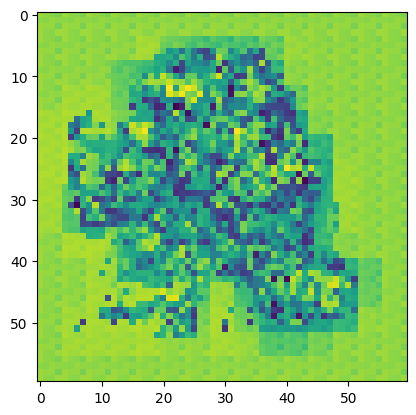

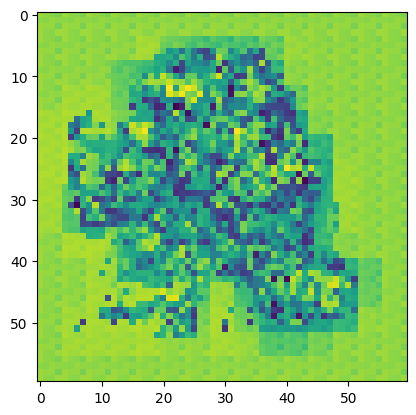

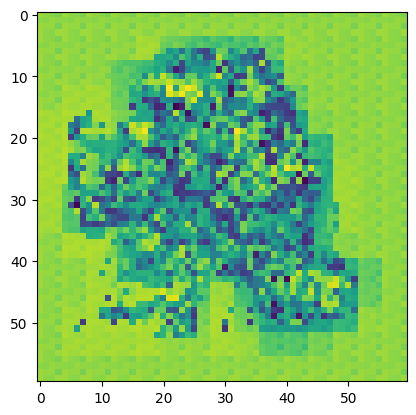

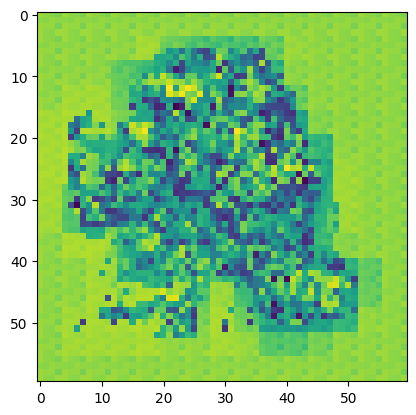

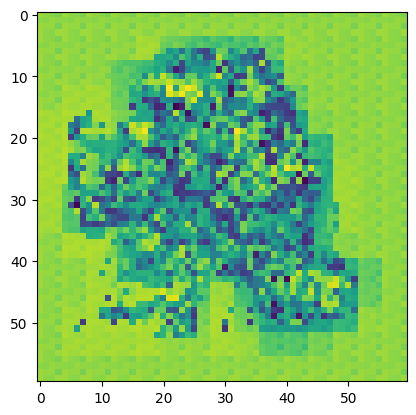

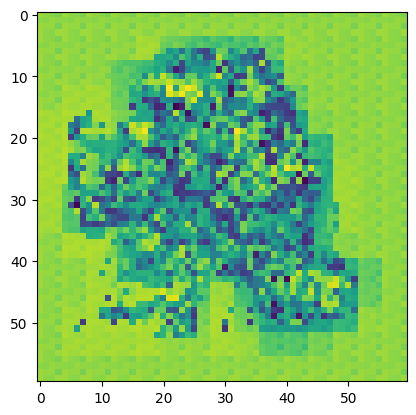

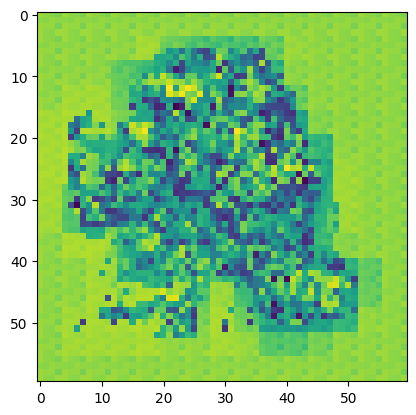

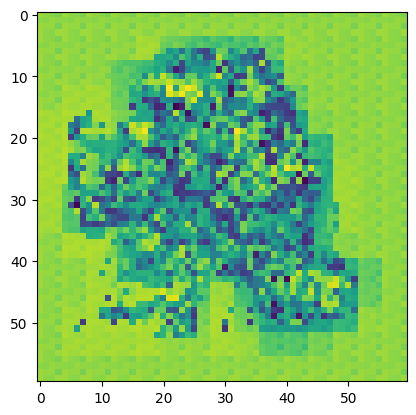

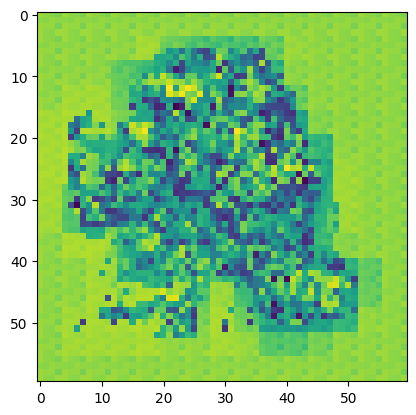

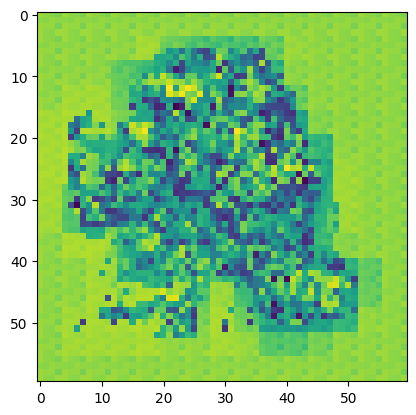

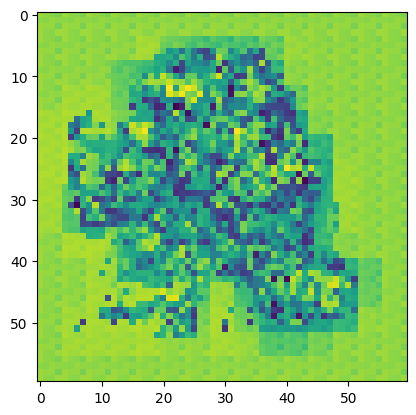

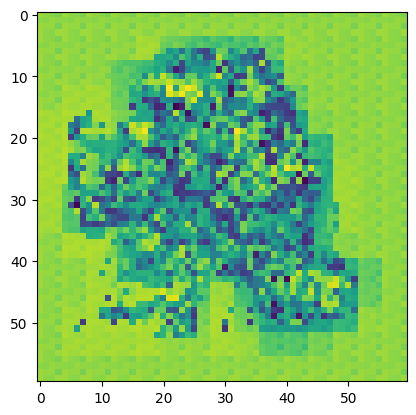

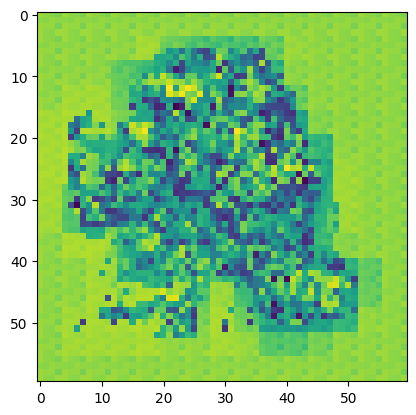

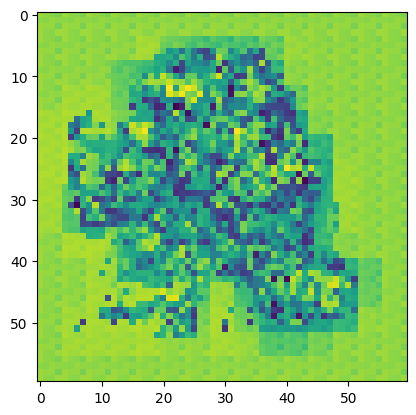

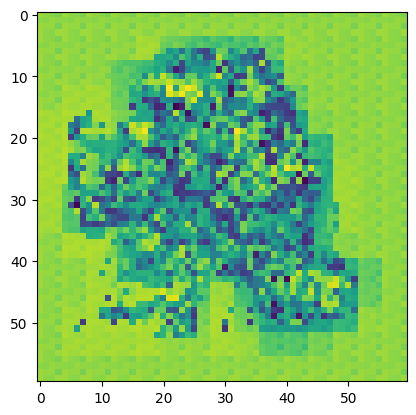

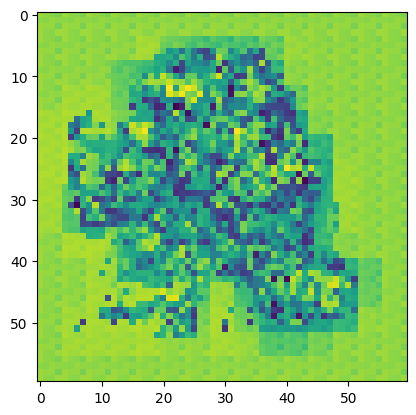

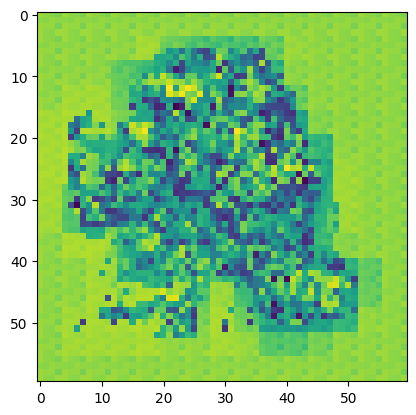

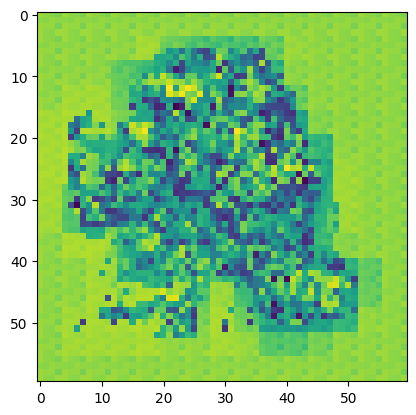

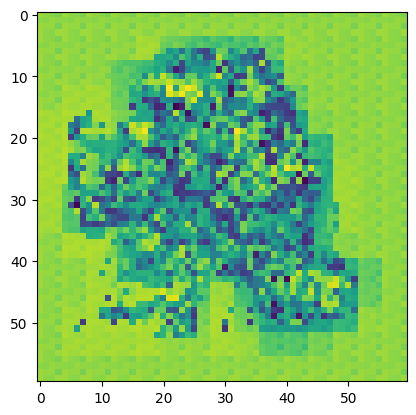

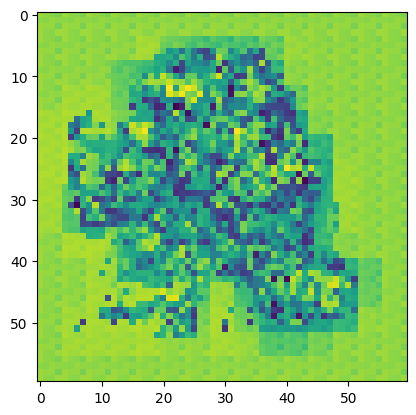

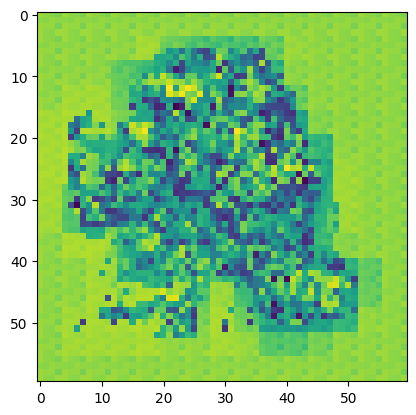

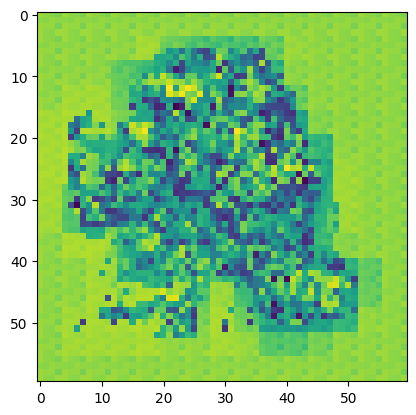

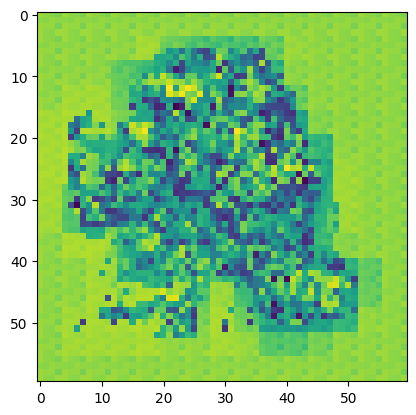

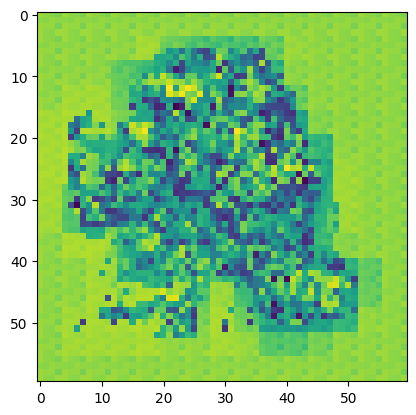

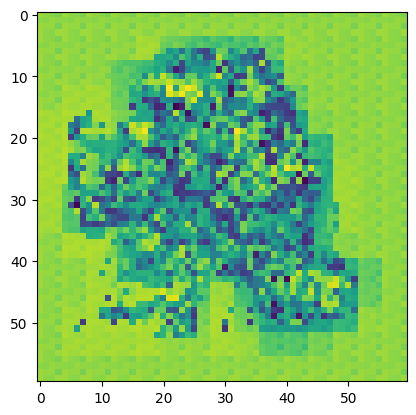

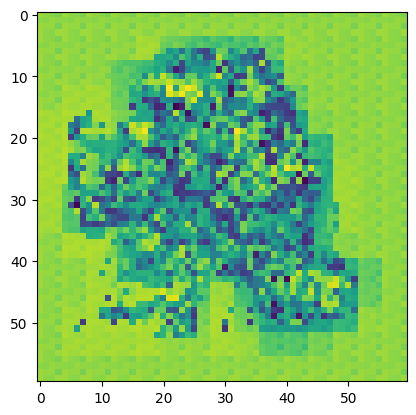

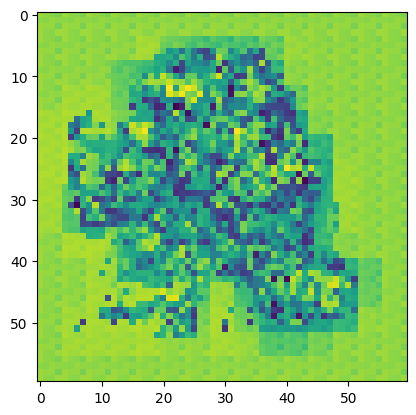

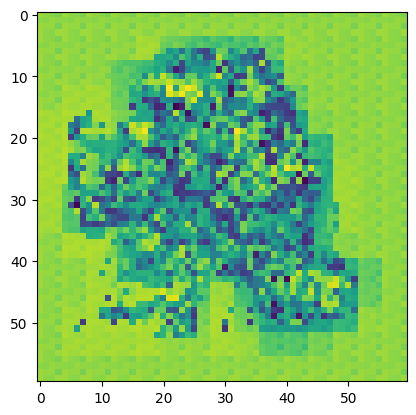

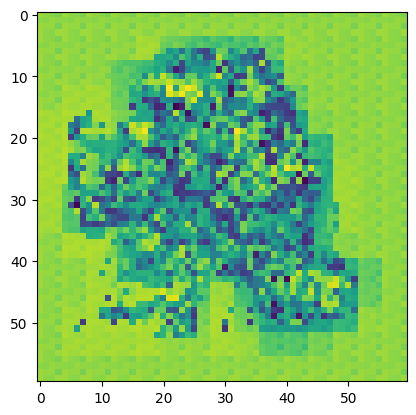

In [31]:
for i in range(100):
    plt.imshow(dists[0, :, :, i])
    plt.show()

In [22]:
# yaml.safe_dump(mushroom_config, open(os.path.join(out_dir, 'mushroom_config.yaml'), 'w'))

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

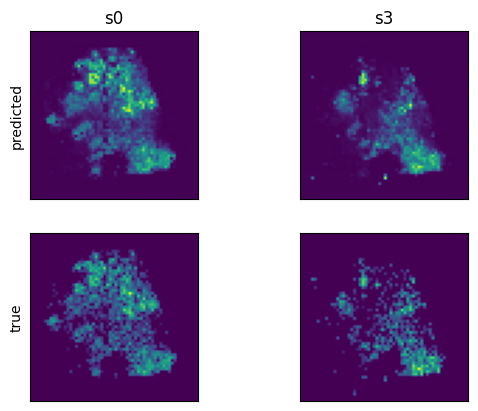

In [20]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

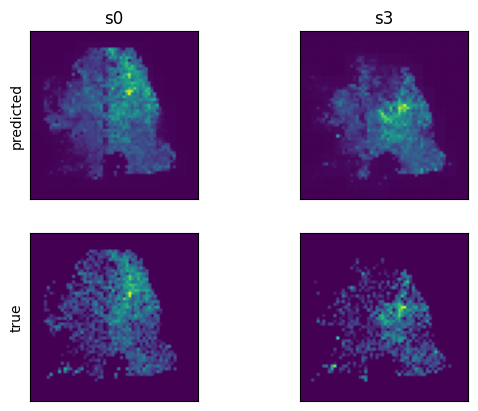

In [21]:
mushroom.display_predicted_pixels(channel='ACTA2')

In [22]:
mushroom.cluster_sections(margin=.1)

INFO:root:no background channel detected, defaulting to mean of all channels
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 13] Permission denied: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/data/estorrs/miniconda3/en

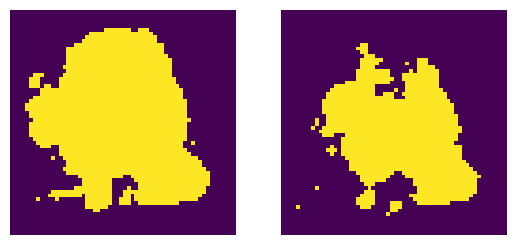

In [23]:
mushroom.clusterer.display_section_masks()

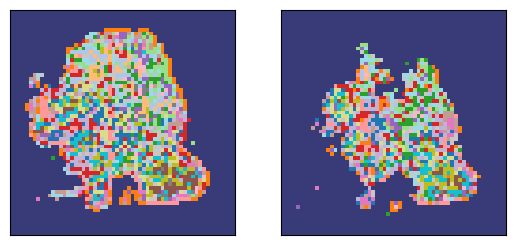

In [24]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

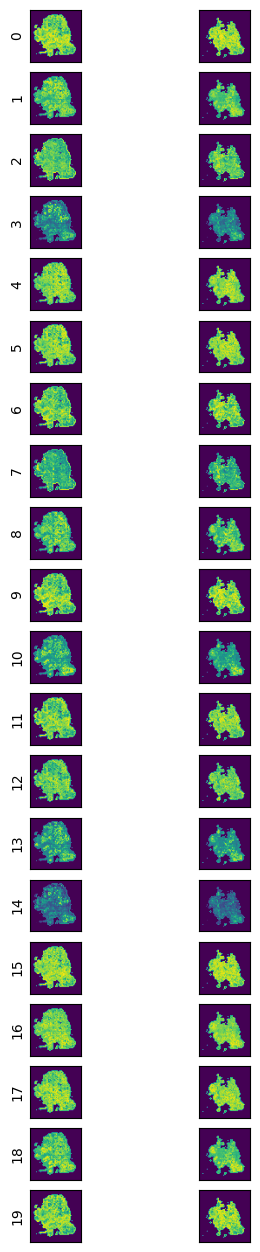

In [25]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

In [53]:
embs = mushroom.recon_embs.clone().detach().numpy()
embs.shape

(2, 1024, 60, 60)

In [55]:
from einops import rearrange
x = rearrange(embs, 'n d h w -> (n h w) d')
x.shape

(7200, 1024)

In [56]:
from umap import UMAP
u = UMAP(n_components=20)
decomp = u.fit_transform(x)
decomp.shape

(7200, 20)

In [57]:
xx = rearrange(decomp, '(n h w) d -> n d h w', n=2, h=60, w=60)
xx.shape

(2, 20, 60, 60)

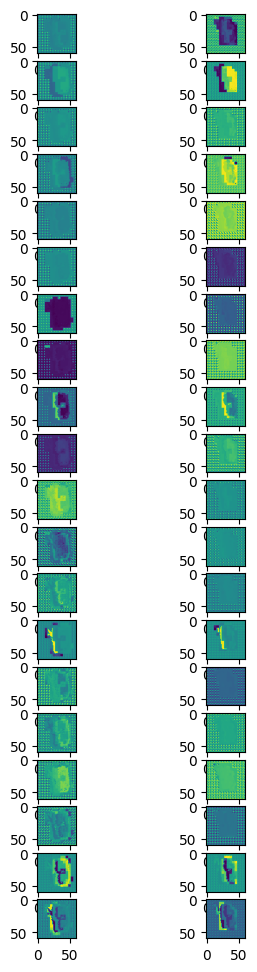

In [61]:
fig, axs = plt.subplots(nrows=xx.shape[1], ncols=xx.shape[0], figsize=(4, 12))
for i in range(xx.shape[1]):
    for j in range(xx.shape[0]):
        ax = axs[i, j]
        ax.imshow(xx[j, i])

In [ ]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/400iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [108]:
config = yaml.safe_load(open(config_fps[-3]))
config = visium_to_ome(config)

s0
s0 0 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff
s3
s3 3 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff


In [109]:
config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath